First, an admission for anyone who may ever review this as it's public:

I’m by no means an expert in EEG analysis and I'm not a neurologist. My wife and daughter have suffered greatly from Epilepsy, especially my daughter, who had half her brain removed to save her life at 6 months of age. Her conditions were so rare, we were asked to donate it Boston Children's Hospital for research. The datasets I use in this capstone are from that hospital.

My interest began when I found out Epilepsy was in a field of mathematics (nonlinear dynamics) on the frontiers of mathematical research that dealt with nonlinear differential equations, the variables of which were considered continuous, and if that weren't enough, it was considered to be a complex problem with regard to Spatio-temporality.

I taught myself the math needed to understand what that meant. That entailed mostly Linear Algebra, Differential Equations, Vector Calc, and some Probability Theory in so far as Chaos Theory and Markov Chains were concerned.

Along the way I learned, mostly via Gilbert Strang, Steven Strogatz, and youtube's Grant Sanderson at 3Brown1Blue, that life in general is chaotic and unpredictable and very nonlinear. The only hope is to model it somehow. The mathematical somehow is generally to scale way down and 'linearize' everything and sum it all back up for a bigger picture or to approximate something in an area and understand it before getting too far away and the errors build. This led  me to taking python master classes through Udemy (so I could model my own systems of differential equations) which then led to the need for data in order to model which led to Springboard Data Camp.

Shout out to Strang and Strogatz for the math and Grant to help visualize these concepts. If no one has ever visited Grant's page, 3Brown1Blue, it's very impressive.

So bear this in mind as you read: My analysis is purely based in my experience dealing with pediatric neurologists, brain surgeries, all the resulting EEGs that I've spent hours watching, and reading lots and lots and asking lots and lots.

My hope is that I find a diamond in the rough with my own modeling as I learn to model. Ive watched my daughter dying and as the hospital's emergency teams saved her life, the ER's emergency team was taking my wife downstairs to the ER from having uncontrollable seizures. Events like this underpin my motivations.

My wife and I have had many battles with insurance companies for medicinal approvals that resulted in untold amounts of stress that ended with peer to peer reviews between insurance company doctors and their counterparts at the hospitals. The largest battle dealt directly with EEG readings from before and after my daughter's brain surgery: the medicine was denied and denied because the required diagnoses was based on EEG readings from a full-sized brain, and my daughter had half a brain.

The initial goals for capstones two and three were  meant to find a way to see the required patterns after a brain surgery that will save insurance companies and hospitals money and make the approval process less painful for parents. They were also tp serve as a vehicle to learn data science, so I can get into the field for a career. And those are still the goals, but as I've gone through the course, learning more from Springboard and my research, I've become much more interesting to my wife's and daughter's neurologists and this has led me to generalize my goals to encompass any diamond in the rough that may present itself for anyone that deals directly with the brain. These doctors and hospitals have been very open about the lack of data in this field, and how it's hard to clean and process and standardize it. They are sending me raw data from  my daughter's EEGs from before and after her brain surgery and now a medical device company is sending me the raw data from the Deep Brain Stimulator surgically implanted in her brain.

So what started out as a personal goal has begun morphing into something potentially larger.

So keep in mind that none of this may find anything. And my assumptions and analysis are purely from my intuition,  personal experience, and the external support I receive from hospitals. So I'd like to thank the Medical University of South Caroline, Children's Healthcare of Atlanta, and Prisma Health their help and support.

As we begin getting into the heart of the capstone, I'd like to start with a general overview of where this is heading, partly because it keeps me organized, and partly so domain knowledge is explained. These capstones are heading in the direction of Bayesian Inference where "prior probabilities" will need to be established. This is dependent upon said domain knowledge.

I don't believe GitHub is going to allow me to upload this amount of data; therefore, we will be relying on these notebooks as well as these descriptions for explanation.

General Overview:

I know I've listed these general overviews in previous assignments, but it's cumbersome to review those, and more importantly, the plan is changing as things develop over time, and that is the case since I turned in the data wrangling notebook.

- There are 6 separate .edf files read in through mne-python, which converts them to numpy arrays that are then put into a pandas dataframes.

- Each data point in the dataframe represents an electrical reading measured in Amperes. These units are consistent throughout all files. I will normalize these in the modeling stage, but not in the EDA stage. The range of values can be large and their domain is the positive and negative Real number system.

- Normalization will occur in modeling in order to reduce the vast amount of noise in the data resulting from motor skill activity, although the experimenters that captured the data attempted to control for that, so the data is less noisy than would normally be the case.

- These 6 .edf files are reduced to 3 files, each of which are ~2 hours of continuous readings. Continuous in time, that is. All 3 files have baseline readings until a diagnosed seizure at the end. There are 256 readings per second so the datasets contain ~ 1.6 million rows. I converted the time column into a zero-based integer index to make things easier.

- Since each of these 3 files end in a recorded seizure,  each file can be separated into 2 separate dataframes:
   1. The X set contains the massive amount of data leading up to the seizure but does not contain it.
   2. The y set contains only the seizure.

- The first row in the y set is the next moment in time from the last row of the X set.

- These X and y sets will become the training and test sets for the modeling stage.

- The X and y variable names will also contain other information in them so keeping track of what's going on will be easier.

- There are 2 patients.

- Patient 1 is always identified by the number 1 somewhere in the variable, dictionary key, or dataset. Patient will 2 will always have a 2 somewhere in the name.

- Patient 1 has an intial EEG and then another recorded 18 months later.

- Patient 2 only has one EEG recording, but it's unique in that this patient has a VNS device surgically inserted in an attempt to control seizures.

It's important to understand that I couldn't come up with a plan to split a single X and y into training and testing sets. I couldn't quickly find a way to make a 10,000 x 23 matrix of data points a "target" data frame.

This led to Bayesian Inference.

A general and early goal is to identify changes in EEG numerical data points that identify a seizure is approaching. Epileptics often talk about auras before a seizure. These auras no doubt exist in the form of electricity produced by neurons. I wonder if there is a stage before the aura, a pre-aura, that can be identified. Thus:

a. normal  EEG -> (threshold to) -> b. pre-aura EEG, if it exists -> (threshold to) -> c. aura EEG, if it exists -> (threshold)  ->  d. seizure

The sets a, b, c, and d are cutouts form the data. The thresholds are when the change occurs. To use a term from nonlinear dynamics, the threshold would be the point in time when the "bifurcation" occurs, and the seizure starts the process of becoming chaotic and uncontrolled.

The alternate hypothesis is then:
   There are patterns identifying pre-auras in the X_train that lead to auras that lead to the seizure.

The null hypothesis is then:
   The seizure comes from nowhere and nothing in the data before it will matter.



In [98]:
"""Functions to be called when needed since there are 3 patients """

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import warnings  # Hide all warnings here
import random

mne.set_log_level('WARNING')
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

master_data_patient_dict = {}

added_columns = ['seizure = 1','outer_left_hemi_sum','inner_left_hemi_sum','outter_right_hemi_sum',
				 'inner_right_hemi_sum','center_line','left_temple_to_left_rear','temple_to_temple',
				 'right_temple_to_right_rear']

program_functions = ['compare_describe_methods(dfx,dfy)', ' sns_line(data,x,y', 'equally_sized_data_sets_leading_to_seizure(X: str, y: str, patient: str)', 'compare_describes(**kwargs)', 'distribution_plot(data=None, kind="hist")']

def load_pandas_data(filename):
	""" converts raw data from an .edf file to a dataframe"""

	mne.set_log_level('WARNING')
	warnings.simplefilter("ignore")

	patient = mne.io.read_raw(filename,preload=True)
	return patient.to_data_frame()


def prepare_df_for_analysis(preseizure_set,seizure_set,start,end):
	"""

	Prepares a master dataframe for the analysis.
	:param preseizure_set: a full EEG set without a seizure
	:param seizure_set: an EEG with a seizure and then truncated after the seizure
	to reduce file size
	:param start: start time of the seizure as listed in the summary file from Children's hospital data set
	:param end: end time of the seizure as listed in the summary file from Children's hospital data set
	:return: a dataframe

	"""

	preseizure_set.set_index('time',inplace=True)
	seizure_set.set_index('time',inplace=True)

	preseizure_set['seizure = 1'] = 0
	seizure_set['seizure = 1'] = 0

	seizure_set.loc[start: end,'seizure = 1'] = 1

	patient = pd.concat([preseizure_set,seizure_set],axis=0,ignore_index=True)

	# left hemisphere location totals
	patient['outer_left_hemi_sum'] = patient[['FP1-F7','F7-T7','T7-P7','P7-O1']].sum(axis=1)
	patient['inner_left_hemi_sum'] = patient[['FP1-F3','F3-C3','C3-P3','P3-O1']].sum(axis=1)

	# right hemisphere location totals
	patient['outter_right_hemi_sum'] = patient[['FP2-F8','F8-T8','T8-P8-0','P8-O2']].sum(axis=1)
	patient['inner_right_hemi_sum'] = patient[['FP2-F4','F4-C4','C4-P4','P4-O2']].sum(axis=1)

	# center totals
	patient['center_line'] = patient[['FZ-CZ','CZ-PZ']].sum(axis=1)

	# left temple to rear totals
	patient['left_temple_to_left_rear'] = patient[['FZ-CZ','CZ-PZ']].sum(axis=1)

	# temple to temple totals
	patient['temple_to_temple'] = patient[['FT9-FT10']].sum(axis=1)

	# left temple to rear totals
	patient['right_temple_to_right_rear'] = patient[['FT10-T8','T8-P8-1']].sum(axis=1)

	# reorder columns for better visual early analysis
	new_cols = ['seizure = 1',
				'FP1-F7','F7-T7','T7-P7','P7-O1','outer_left_hemi_sum',
				'FP1-F3','F3-C3','C3-P3','P3-O1','inner_left_hemi_sum',
				'FP2-F8','F8-T8','T8-P8-0','P8-O2','outter_right_hemi_sum',
				'FP2-F4','F4-C4','C4-P4','P4-O2','inner_right_hemi_sum',
				'FZ-CZ','CZ-PZ','center_line',
				'P7-T7','T7-FT9','left_temple_to_left_rear',
				'FT9-FT10','temple_to_temple',
				'FT10-T8','T8-P8-1','right_temple_to_right_rear']

	patient = patient.reindex(columns=new_cols)
	patient.set_index(create_int_index(patient),inplace=True)

	locations = seizure_location(patient)
	patient = patient.iloc[: locations[1] + 1,:]

	return patient


def is_df_clean(df):
	""" Check if a dataframe is clean. """
	for i in range(df.count().all().tolist()):
		if not i:
			return f"There are null values in {df.columns[i]}: "f"Note: this is expected if column is 'seizures = 1' as most of the values are zero, but 1 where the seizure exist."
	for j in np.isinf(df).sum().any().to_list():
		if not j:
			return f'There are infinite values in {df.columns[j]}'


def create_int_index(df):
	"""Create and return an index that is `int` based"""
	return np.linspace(0,len(df),len(df),dtype=int)


def seizure_location(df):
	"""Return the index locations of the seizure."""

	seizure_location = df.index[df['seizure = 1'] != 0].tolist()
	# seizure_start, seizure_end = seizure_location[0], seizure_location[-1]

	return seizure_location[0],seizure_location[-1]


def make_needed_dataframe(master_df,columns: list,patient: str,master_dict) -> dict:
	# sourcery skip: dict-literal, merge-dict-assign
	"""
    Make a variety of  X, y training and test sets for a variety of EDA and modeling needs.
    """

	local_patient_dict = dict()

	# have a master with seizure column but NOT seizure columns
	local_patient_dict['all data minus seizure column'] = master_df.drop(columns[0],axis=1,inplace=False)

	# have a master without any added columns
	local_patient_dict['all data minus added columns'] = master_df.drop(columns,axis=1,inplace=False)

	# have a master with only summary columns
	local_patient_dict['X only summary columns'] = master_df[columns[1:]]

	# create the Xs
	local_patient_dict['X all columns'] = master_df[master_df['seizure = 1'] != 1]
	local_patient_dict['X no added columns'] = local_patient_dict['X all columns'].drop(columns,axis=1,
																						inplace=False)
	local_patient_dict['X only summary columns'] = local_patient_dict['X all columns'][columns[1:]]

	# create the ys
	local_patient_dict['y all columns'] = master_df[master_df['seizure = 1'] != 0]
	local_patient_dict['y no added column'] = local_patient_dict['y all columns'].drop(columns,axis=1,
																					   inplace=False)
	local_patient_dict['y only summary columns'] = local_patient_dict['y all columns'][columns[1:]]

	master_dict[patient] = local_patient_dict

	return master_dict


def compare_describe_methods(dfx,dfy):
	global master_data_patient_dict
	X_train_describe = master_data_patient_dict['Patient 1 initial set'][dfx].describe().transpose()
	y_train_describe = master_data_patient_dict['Patient 1 initial set'][dfy].describe().transpose()
	trains_compared = pd.concat([X_train_describe,y_train_describe],axis=1)
	trains_compared.columns = ['count_X','mean_X','std_X','min_X','25%_X','50%_X','75%_X','max_X','count_y','mean_y','std_y',
							   'min_y','25%_y','50%_y','75%_y','max_y']
	return trains_compared.sort_index(axis=1)


def sns_line(data,x,y,fit_reg=True,n_boot=2000,seed=911,logx=False,truncate=True):
	return sns.regplot(data=data,x=x,y=y,fit_reg=fit_reg,n_boot=n_boot,seed=seed,logx=logx,truncate=truncate)


def equally_sized_data_sets_leading_to_seizure(X: str, y: str, patient: str):
	""" Create four separate data sets for analysis, each of are equal in length to the patient's seizure set and are chronologically ordered ending in the final set: the seizure set. The four sets are then:
	 X_set_normal --> X_set_pre_aura --> X_set_aura --> y_set_seizure
	"""

	patient = {}
	y_length = len(y)
	X_original_length = len(X)

	X_set_aura_beginning_index = X_original_length - y_length
	X_set_pre_aura_beginning_index = X_set_aura_beginning_index - y_length
	X_set_normal_beginning = X_set_pre_aura_beginning_index - y_length

	patient['X_set_normal'] = X[X_set_normal_beginning: X_set_pre_aura_beginning_index]
	patient['X_set_pre_aura'] = X[X_set_pre_aura_beginning_index: X_set_aura_beginning_index]
	patient['X_set_aura'] = X[X_set_aura_beginning_index:]
	patient['y_set_seizure'] = y

	test = (
			(patient['X_set_normal'].index[0], patient['X_set_normal'].index[-1]),
			(patient['X_set_pre_aura'].index[0], patient['X_set_pre_aura'].index[-1]),
			(patient['X_set_aura'].index[0], patient['X_set_aura'].index[-1]),
			(patient['y_set_seizure'].index[0], patient['y_set_seizure'].index[-1]))

	print(test)
	return patient


def compare_describes(**kwargs):

	global patient

	# dfs = kwargs
	X_normal = kwargs['X_norm'].describe().transpose()
	X_pre = kwargs['X_pre_aura'].describe().transpose()
	X_aura = kwargs['X_aura'].describe().transpose()
	y_seizure = kwargs['y_set_seizure'].describe().transpose()

	sets_compared  = pd.concat([X_normal, X_pre, X_aura, y_seizure],axis=1)

	sets_compared.columns = ['cnt_a_norm', 'mean_a_norm', 'std_a_norm', 'min_a_norm', '25%_a_norm', '50%_a_norm', '75%_a_norm', 'max_a_norm', 'count_b_pre_aura', 'mean_b_pre_aura', 'std_b_pre_aura', 'min_b_pre_aura', '25%_b_pre_aura', '50%_b_pre_aura', '75%_b_pre_aura', 'max_b_pre_aura', 'count_c_aura', 'mean_c_aura', 'std_c_aura', 'min_c_aura', '25%_c_aura', '50%_c_aura', '75%_c_aura', 'max_c_aura', 'count_seizure', 'mean_seizure', 'std_seizure', 'min_seizure', '25%_seizure', '50%_seizure', '75%_seizure', 'max_seizure']

	return sets_compared.sort_index(axis=1)


def distribution_plot(data=None, kind='hist', legend =True):
	return sns.displot(data=data, kind=kind, legend = legend)

In [99]:
# identify the raw .edf files

raw_p1_02_nonseizure = '/Users/jshensley/Desktop/springboard/DS_Method_and_Capstones/capstone_2_2/capstone_2/a_cookiecutter_for_capstone_2/{{ cookiecutter.seizure_prediction_model }}/notebooks/Capstone2_dataset/patient_1/intial_EEG/chb01_02_nonseizure_set_just_before_seizure_set.edf'

raw_p1_02_seizure_set = '/Users/jshensley/Desktop/springboard/DS_Method_and_Capstones/capstone_2_2/capstone_2/a_cookiecutter_for_capstone_2/{{ cookiecutter.seizure_prediction_model }}/notebooks/Capstone2_dataset/patient_1/intial_EEG/chb01_02_nonseizure_set_just_before_seizure_set.edf'

In [100]:
# load the .edf files and convert the underlying numpy arrays to a dataframe

p1_preseizure = load_pandas_data(raw_p1_02_nonseizure)
p1_seizure = load_pandas_data(raw_p1_02_seizure_set)

# run through a sequence of dataframe preprocessing for later modeling
p1_datasets = make_needed_dataframe(
		master_df=prepare_df_for_analysis(
				preseizure_set=p1_preseizure,
				seizure_set=p1_seizure,
				start=2996,
				end=3036),
		columns=added_columns,
		patient='Patient 1 initial set',
		master_dict=master_data_patient_dict)

In [101]:
master_data_patient_dict['Patient 1 initial set']['all data minus seizure column'].head()

,FP1-F7,F7-T7,T7-P7,P7-O1,outer_left_hemi_sum,FP1-F3,F3-C3,C3-P3,P3-O1,inner_left_hemi_sum,...,CZ-PZ,center_line,P7-T7,T7-FT9,left_temple_to_left_rear,FT9-FT10,temple_to_temple,FT10-T8,T8-P8-1,right_temple_to_right_rear
0,15.042735,15.042735,28.327228,-13.479853,44.932845,40.830281,-12.307692,-12.307692,28.717949,44.932845,...,-26.373626,-58.998779,-27.936508,-47.863248,-58.998779,-25.592186,-25.592186,54.896215,-27.155067,27.741148
1,0.195360,0.195360,0.195360,0.195360,0.781441,0.195360,0.195360,0.195360,0.195360,0.781441,...,0.195360,0.390720,0.195360,0.195360,0.390720,0.195360,0.195360,0.195360,0.195360,0.390720
2,0.195360,0.195360,0.195360,0.195360,0.781441,0.195360,0.195360,0.195360,0.195360,0.781441,...,0.195360,0.390720,0.195360,0.195360,0.390720,0.195360,0.195360,0.195360,0.195360,0.390720
3,-0.195360,0.195360,0.195360,0.195360,0.390720,-0.195360,0.195360,0.195360,0.195360,0.390720,...,0.195360,0.390720,0.195360,0.195360,0.390720,0.195360,0.195360,0.195360,0.195360,0.390720
4,-0.195360,0.976801,0.195360,0.195360,1.172161,0.195360,0.195360,-0.195360,0.586081,0.781441,...,0.195360,0.390720,0.195360,-1.758242,0.390720,0.586081,0.586081,0.586081,0.586081,1.172161


The various datasets will be stored in a python dictionary, the keys of which identify the patient and the values of which are that patient's datasets.
For example:

In [102]:
available_datasets = master_data_patient_dict['Patient 1 initial set']
for k in available_datasets.keys():
	print(f'"{k}"\n')

"all data minus seizure column"

"all data minus added columns"

"X only summary columns"

"X all columns"

"X no added columns"

"y all columns"

"y no added column"

"y only summary columns"



Let's spot check a couple of column distributions to get an idea of what they look like.

I'll choose the corresponding columns for the X non-seizure set and y seizure set since the seizure set begins where the non-seizure set ends.

Will there be noticeable differences in standard summary stats?

And I will choose the outer left and outer right hemispheres at the forehead location of the frontal lobe to try and eliminate any potential correlations from the bleeding of signals into other EEG leads.

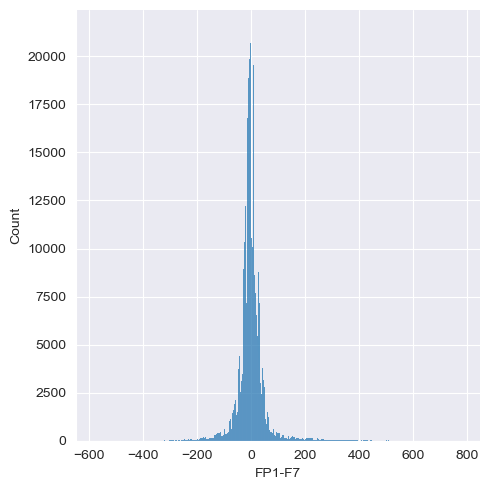

In [103]:
# Left hemisphere non_seizure
distribution_plot(data=master_data_patient_dict['Patient 1 initial set']['X no added columns']['FP1-F7'], kind='hist')

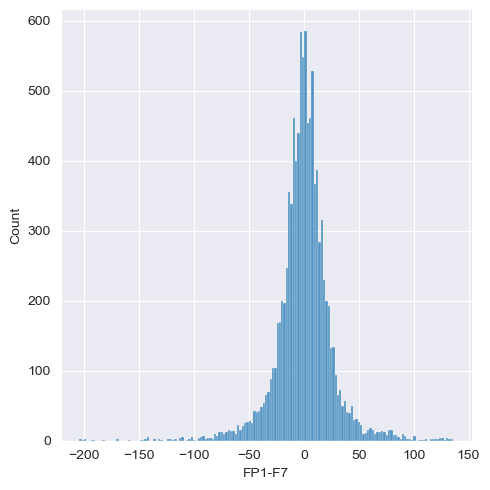

In [104]:
# Left hemisphere seizure
sns.displot(data=master_data_patient_dict['Patient 1 initial set']['y no added column']['FP1-F7'], kind='hist')

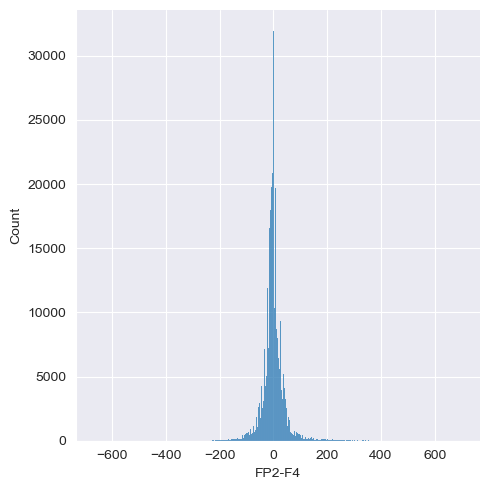

In [105]:
# Right hemisphere non-seizure
sns.displot(data=master_data_patient_dict['Patient 1 initial set']['X no added columns']['FP2-F4'], kind='hist')

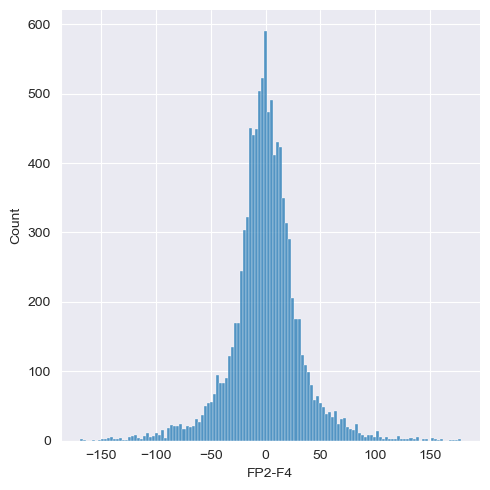

In [106]:
# Right hemisphere seizure

distribution_plot(data=master_data_patient_dict['Patient 1 initial set']['y no added column']['FP2-F4'], kind='hist')

My first inclination is to think the seizure set has a larger deviation but looking closely at the values on the x-axis shows this is not the case. Both sets seem normally distributed and any given data point is approximately in a range between -150 and 150.

It's also clear there are a lot of datapoints.

Is the X set too big?

Let's eyeball some actual numbers.

We'll start with basic descriptions of the X and y datasets then move to the X and y summary datasets.

The two datasets without the added features and their associated regression fits.

I'll use the pd.describe() method on the X and y data frames, rename the .describe() columns and join them so that we can see the X and y set's summaries side by side.

In [107]:
individuals = compare_describe_methods('X no added columns', 'y no added column')
individuals

,25%_X,25%_y,50%_X,50%_y,75%_X,75%_y,count_X,count_y,max_X,max_y,mean_X,mean_y,min_X,min_y,std_X,std_y
FP1-F7,-18.559219,-11.135531,-0.586081,0.195360,16.605617,11.916972,1688576.0,10241.0,779.291819,135.775336,0.230753,0.162015,-580.415140,-204.542125,54.740631,26.069786
F7-T7,-13.089133,-10.354090,0.195360,0.586081,13.089133,11.526252,1688576.0,10241.0,554.236874,91.623932,0.204007,0.078003,-436.239316,-116.239316,31.635561,21.236988
T7-P7,-12.698413,-10.744811,0.195360,0.195360,13.089133,11.916972,1688576.0,10241.0,390.525031,81.855922,0.188780,0.312412,-453.431013,-96.703297,24.839441,19.825202
P7-O1,-11.526252,-11.526252,0.195360,0.195360,11.916972,12.307692,1688576.0,10241.0,221.343101,98.656899,0.236891,0.374677,-304.957265,-76.385836,21.224226,20.283379
FP1-F3,-21.294261,-14.652015,-0.586081,0.195360,18.949939,16.605617,1688576.0,10241.0,674.578755,137.338217,0.225937,0.303141,-619.096459,-133.821734,52.827309,31.127361
F3-C3,-14.652015,-15.042735,0.195360,0.586081,15.433455,15.042735,1688576.0,10241.0,251.819292,201.025641,0.148782,-0.049350,-279.560440,-183.052503,26.156212,31.956879
C3-P3,-10.744811,-10.744811,0.195360,0.195360,11.135531,11.526252,1688576.0,10241.0,208.840049,83.418803,0.211710,0.307338,-224.468864,-87.716728,18.239619,18.688414
P3-O1,-14.652015,-14.261294,-0.195360,-0.195360,14.261294,15.042735,1688576.0,10241.0,233.064713,120.537241,0.265594,0.382041,-245.177045,-99.438339,24.151397,24.295570
FP2-F8,-16.996337,-12.698413,-0.195360,0.195360,15.824176,13.479853,1688576.0,10241.0,608.156288,126.788767,0.222413,0.104557,-555.409035,-162.344322,44.050657,26.606800
F8-T8,-15.824176,-13.870574,-0.586081,0.195360,15.042735,14.261294,1688576.0,10241.0,383.882784,130.695971,0.207983,0.037447,-412.405372,-134.603175,32.992028,26.137961


Lookin at the first row, 68% of the data points fall plus or minus ~55 from the mean 0.23 in the X set and plus or minus ~26 from the mean .16 in the seizure y set. The means are similar, but the spread is more focused during the seizure.

And for some quick plots.

<AxesSubplot:xlabel='mean_X', ylabel='mean_y'>

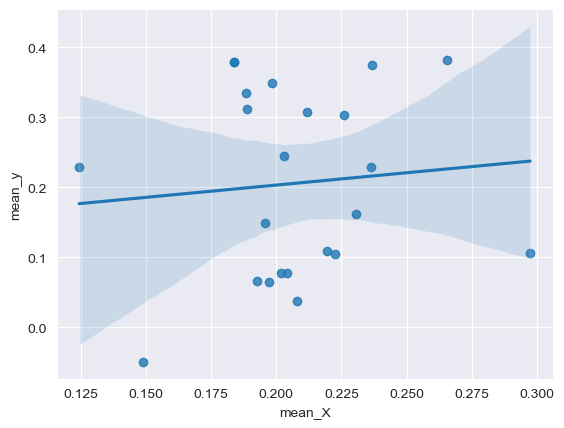

In [108]:
 sns_line(data=individuals, x='mean_X', y='mean_y')

No diamonds in this rough.

While the means are similar, it appears they are not correlated.

On the issue of correlation,  my intuition is correlation will not be a consideration.

Each lead will be picking up energy waves from surrounding areas, saturating everything around it, at minimum in the same hemisphere. There are connections between the hemispheres, notably the Corpus Colosseum, and if that has not been severed by neurosurgeons, then electrical energy from all areas of the brain could be registered by all EEG leads.

In other words, because the brain acts non-linearly across the entire organ, correlation will not be applicable.

This could be why researchers decided to take the differences between each lead rather than utilizing the lead directly.

For example:

In [109]:
master_data_patient_dict['Patient 1 initial set']['X all columns'].head(1).drop('seizure = 1', axis=1)

,FP1-F7,F7-T7,T7-P7,P7-O1,outer_left_hemi_sum,FP1-F3,F3-C3,C3-P3,P3-O1,inner_left_hemi_sum,...,CZ-PZ,center_line,P7-T7,T7-FT9,left_temple_to_left_rear,FT9-FT10,temple_to_temple,FT10-T8,T8-P8-1,right_temple_to_right_rear
0,15.042735,15.042735,28.327228,-13.479853,44.932845,40.830281,-12.307692,-12.307692,28.717949,44.932845,...,-26.373626,-58.998779,-27.936508,-47.863248,-58.998779,-25.592186,-25.592186,54.896215,-27.155067,27.741148


Column 1's  FP1-F7 is exactly what it says it is: lead FP1 minus lead F7 equals the data point in milliamps.

The first data point is positive: so the stronger signal was in the forward area of the frontal lobe and was moving toward the rear.

Then F7-T7 was again positive: the strongest waves are still moving front to back.

Next, T7-P7 is not only positive, but larger, indicating not only is the wave moving front to back, but also picked up additional energy from somewhere.

And it appears that the somewhere is from the next lead, P7-O1 whose value is negative, indicating the energy is traveling back to front, and the collision amounted to the larger number.

The total for the "outer_left_hemi_sum" is 44ish, indicating the general path was front to back.

In the data frame row above, scrolling over to FP2-F8 and moving right to outter_right_hemi_sum, whose value is -4ish, one may conclude the overall energy path was back to front. To see what this looks like:

![](dont_trash_.jpeg)

It's clear how the leads are laid out front to back as the difference between each one and the associated sign of the number indicates which lead is the stronger.

Of course this assists neurologist in identifying from where a seizure starts and maybe this knowledge will assist in establishing the "prior" in Bayes Theorem later on, but let's see if the summaries allow for any insight.

Let's see if the summary columns I added that describe the larger areas of the brain will yield anything.


In [110]:
summaries = compare_describe_methods("X only summary columns", "y only summary columns")
summaries

,25%_X,25%_y,50%_X,50%_y,75%_X,75%_y,count_X,count_y,max_X,max_y,mean_X,mean_y,min_X,min_y,std_X,std_y
outer_left_hemi_sum,-31.648352,-27.741148,3.552714e-15,1.562882,31.257631,30.085470,1688576.0,10241.0,822.075702,313.357753,0.860431,0.927107,-544.664225,-311.013431,72.821711,55.564994
inner_left_hemi_sum,-31.648352,-28.131868,1.776357e-15,1.562882,31.257631,30.085470,1688576.0,10241.0,820.122100,313.748474,0.852023,0.943169,-545.054945,-310.231990,72.763874,55.752882
outter_right_hemi_sum,-32.429792,-28.913309,3.907204e-01,1.562882,32.429792,31.257631,1688576.0,10241.0,963.125763,287.570208,0.812696,0.871443,-1220.610501,-330.940171,73.157846,58.344199
inner_right_hemi_sum,-32.039072,-28.913309,3.907204e-01,1.953602,32.039072,30.866911,1688576.0,10241.0,961.172161,287.960928,0.759570,0.852977,-1215.921856,-330.940171,72.805588,58.217236
center_line,-21.489621,-25.006105,3.907204e-01,1.172161,22.271062,25.006105,1688576.0,10241.0,333.284493,311.404151,0.389912,0.131779,-497.777778,-289.523810,39.011903,49.463665
left_temple_to_left_rear,-21.489621,-25.006105,3.907204e-01,1.172161,22.271062,25.006105,1688576.0,10241.0,333.284493,311.404151,0.389912,0.131779,-497.777778,-289.523810,39.011903,49.463665
temple_to_temple,-20.903541,-16.605617,-1.367521e+00,-0.195360,21.294261,16.605617,1688576.0,10241.0,583.540904,134.212454,0.297334,0.105625,-568.302808,-104.908425,52.193334,27.428797
right_temple_to_right_rear,-19.145299,-18.363858,3.907204e-01,0.781441,19.536020,20.317460,1688576.0,10241.0,393.846154,157.460317,0.403070,0.488086,-358.290598,-186.373626,37.400761,34.434195


Lots of scrolling and figuring things out so let's cut it down.

In [111]:
summaries_reduced = compare_describe_methods("X only summary columns", "y only summary columns")
summaries_reduced = summaries_reduced[['mean_X', 'mean_y', 'std_X', 'std_y']]
summaries_reduced

,mean_X,mean_y,std_X,std_y
outer_left_hemi_sum,0.860431,0.927107,72.821711,55.564994
inner_left_hemi_sum,0.852023,0.943169,72.763874,55.752882
outter_right_hemi_sum,0.812696,0.871443,73.157846,58.344199
inner_right_hemi_sum,0.759570,0.852977,72.805588,58.217236
center_line,0.389912,0.131779,39.011903,49.463665
left_temple_to_left_rear,0.389912,0.131779,39.011903,49.463665
temple_to_temple,0.297334,0.105625,52.193334,27.428797
right_temple_to_right_rear,0.403070,0.488086,37.400761,34.434195


It appears that the differences in the means are more significant than the data earlier and are larger in the y seizure set and the seizure set's std is smaller as before.

How about seeing any correlations from a bird's eye view.

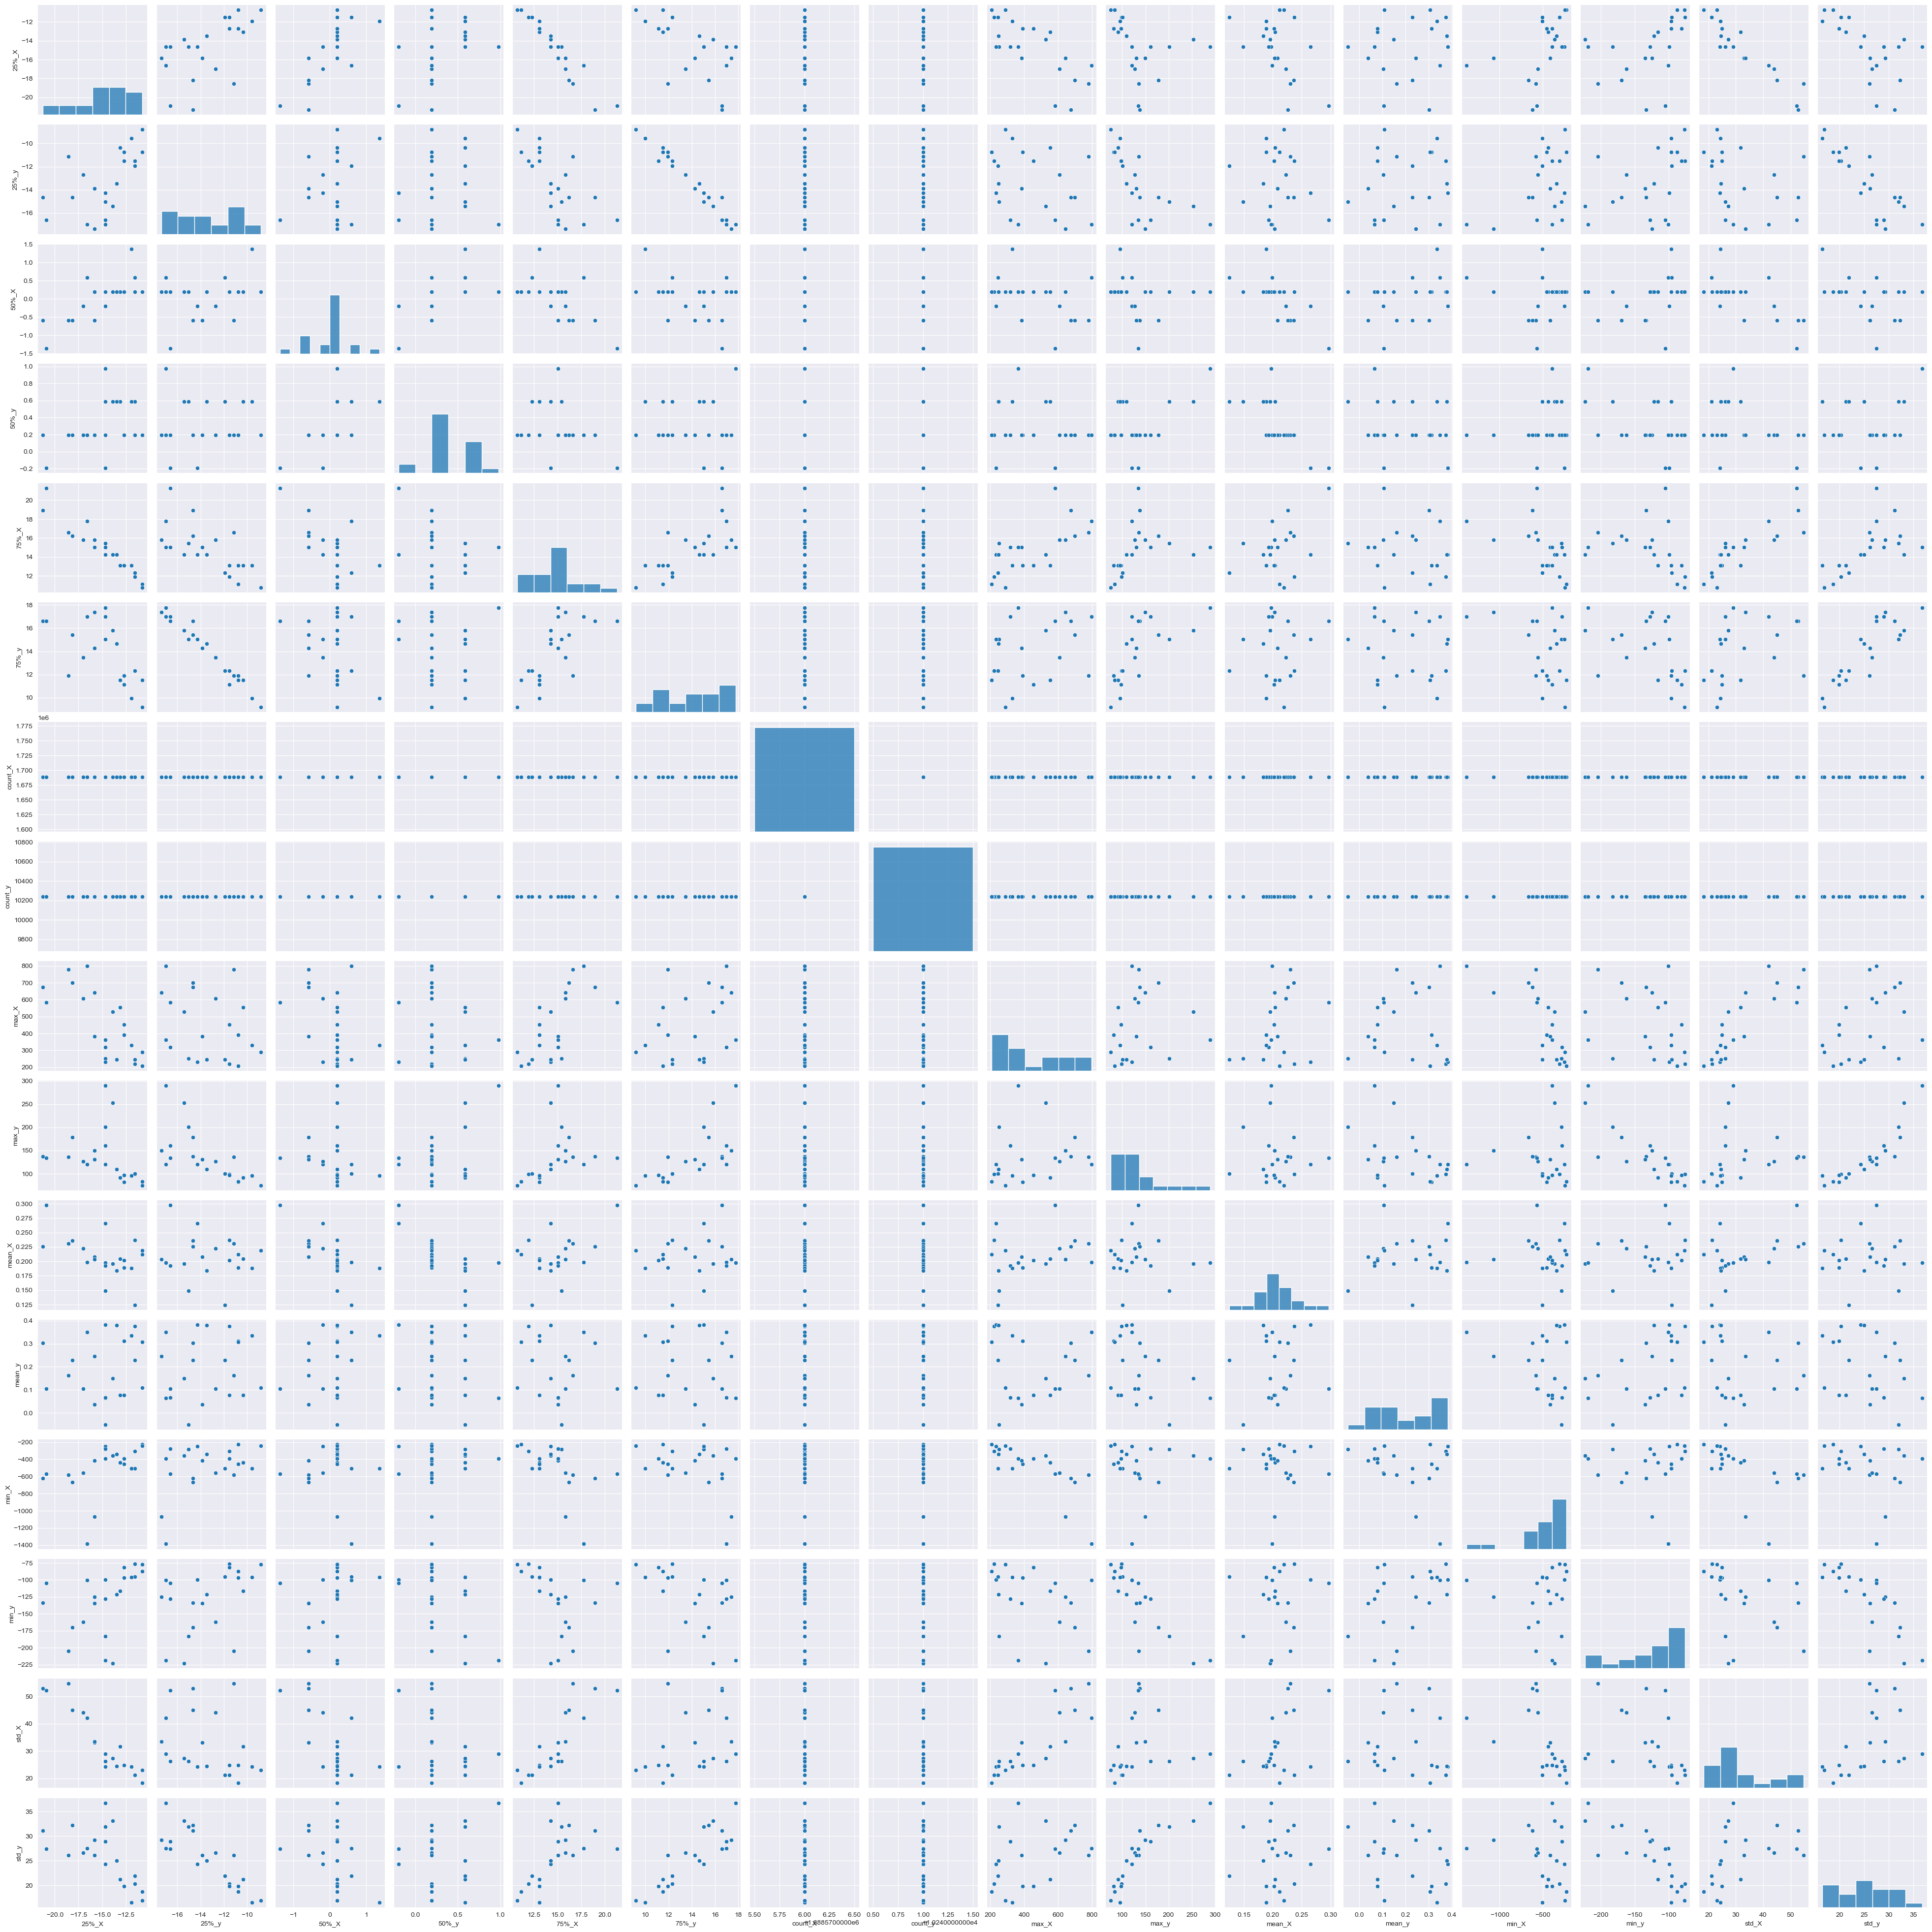

In [112]:
sns.pairplot(data=individuals)

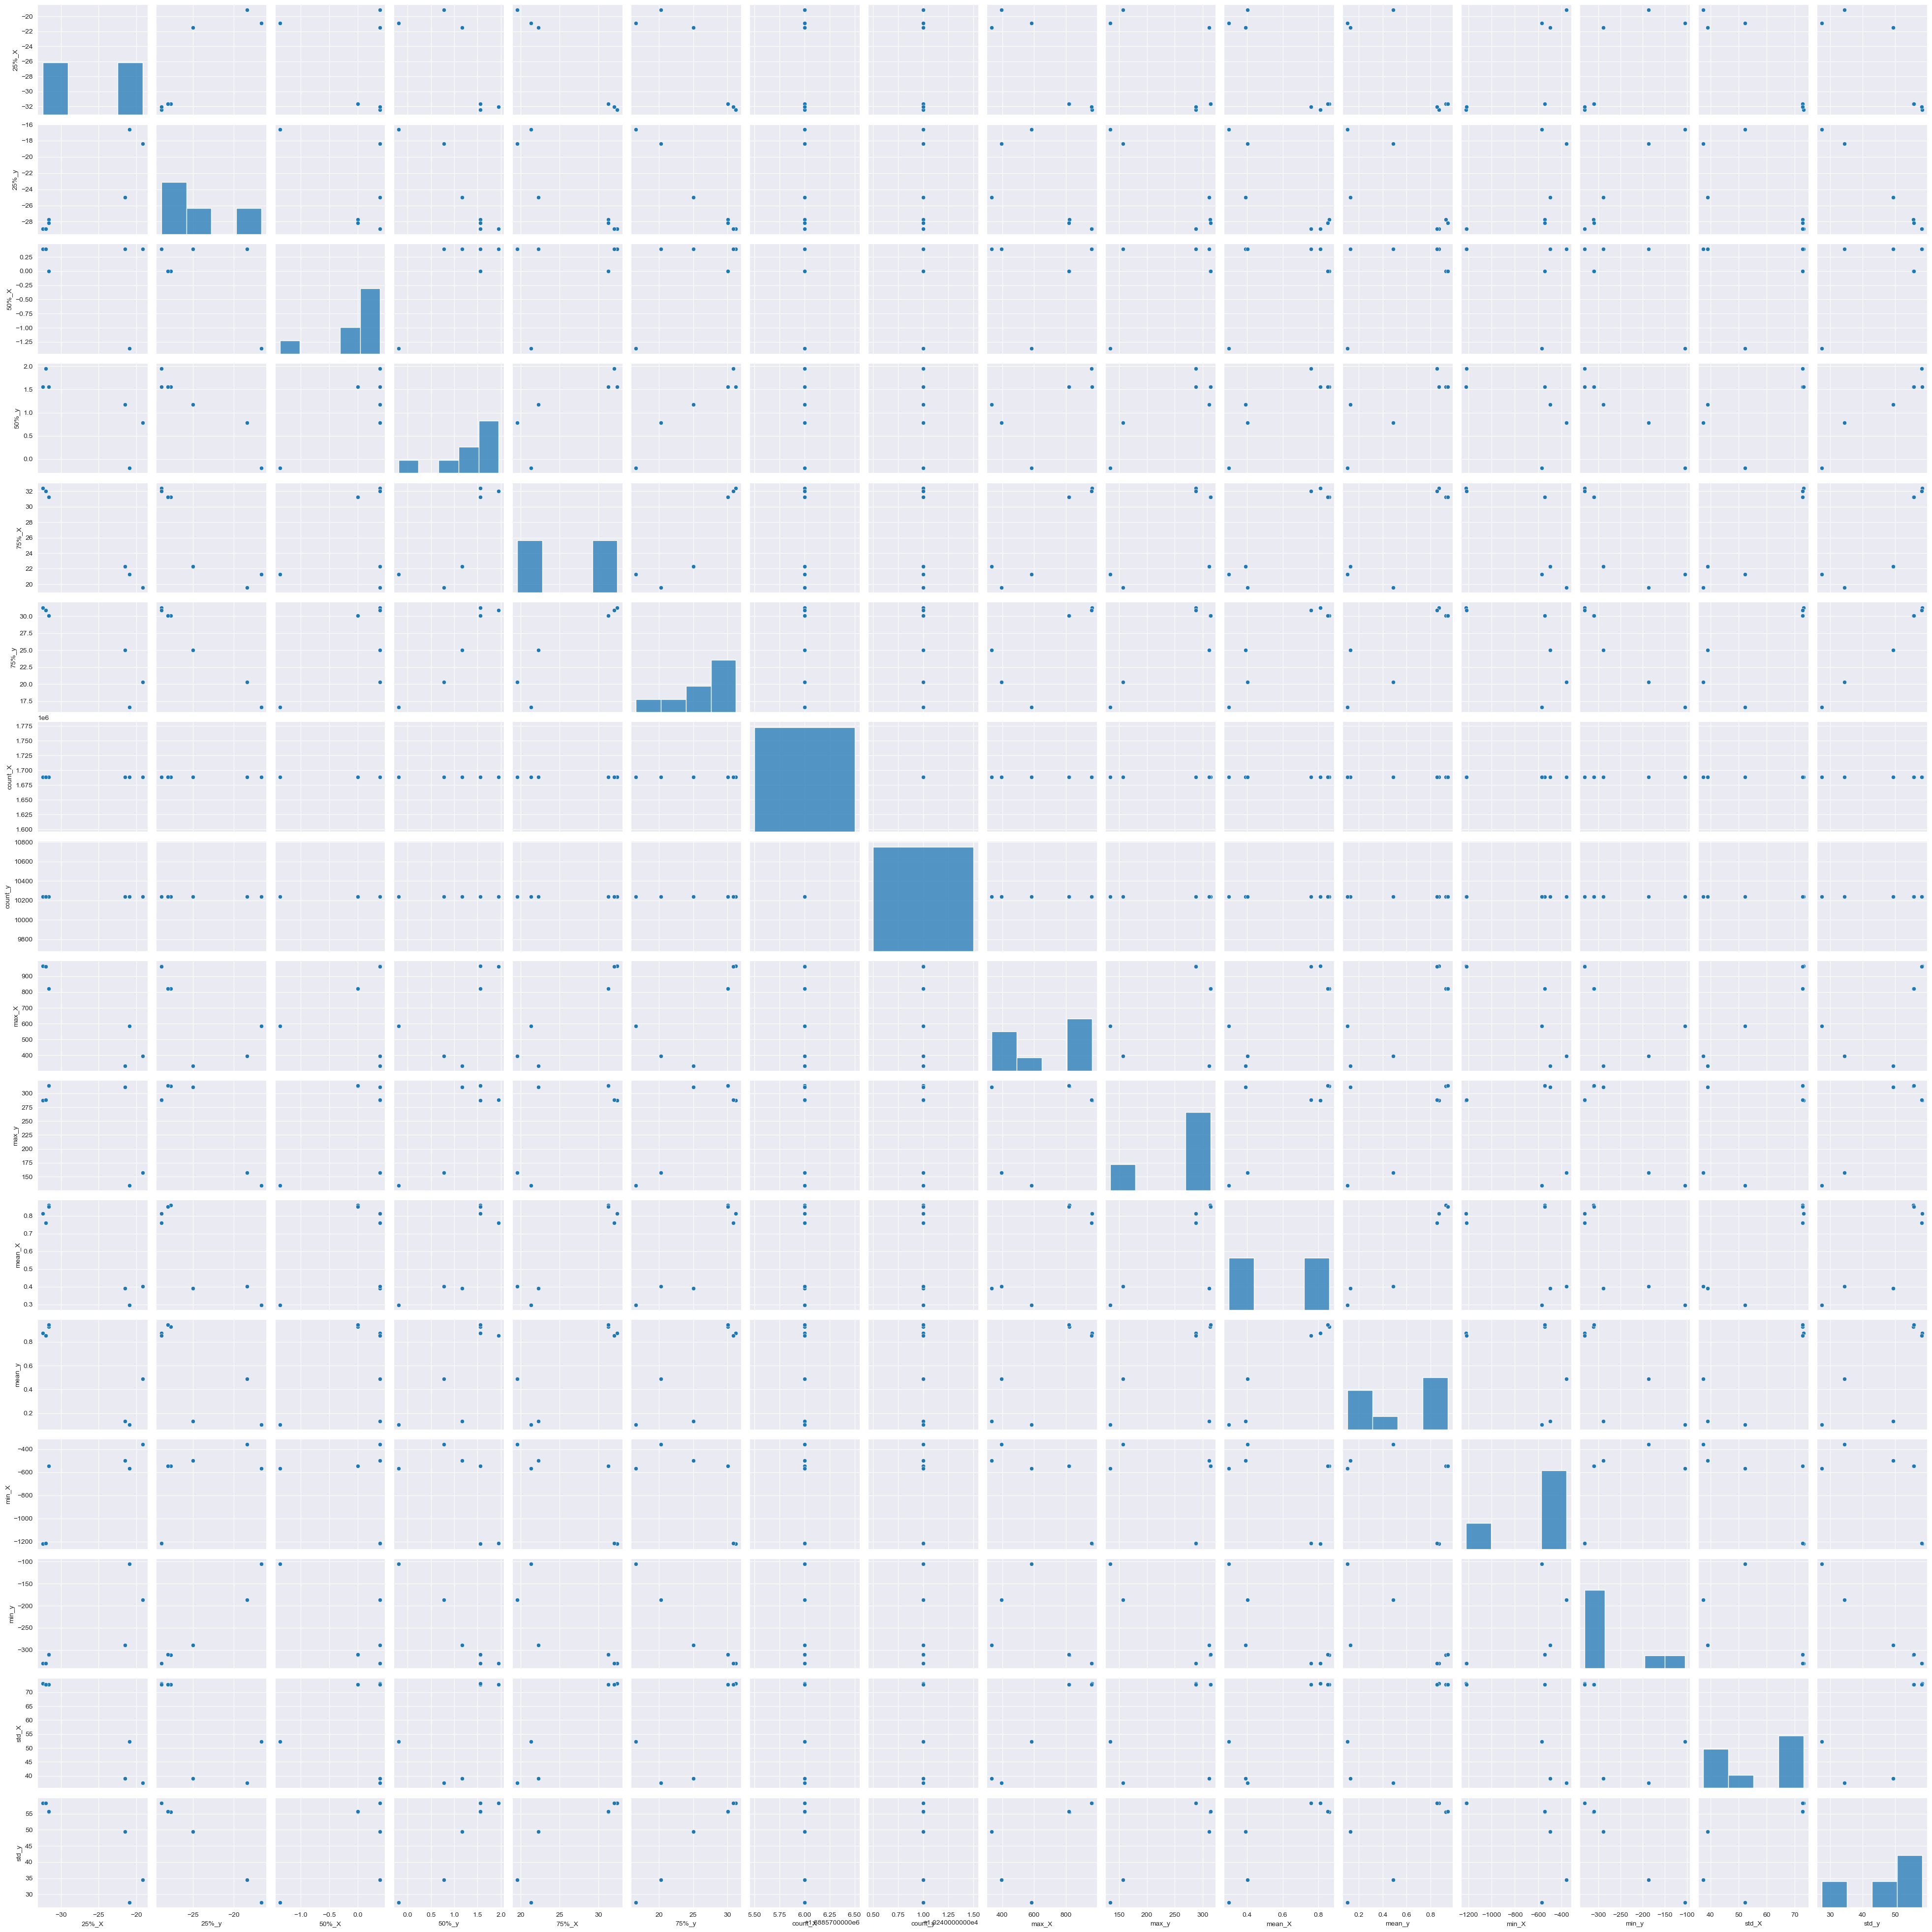

In [113]:
sns.pairplot(data=summaries)

I see no patterns jumping out except chaos, as in the math of Chaos Theory, which by definition is the absence of patterns.

I asked earlier if the X set was too big for what we are analyzing in the y set. At the outset, I was taught the more data in the training set the better. Just like correlation, I’m not so sure that will be needed here. 1.6 million rows to 10241 is a huge difference. Now my intuition is saying that if the seizure is that short compared to the rest, wouldn’t the aura and/or pre-auras also be at similar lengths?

Let's partition the X set into sections with the same length as the seizure dataframe and arbitrarily choose to use the three leading up to the seizure.

X_set_normal :::: X_set_pre-aura :::: X_set_aura :::: y_set_seizure

All four sets are of length 10241: the length of the y_seizure set.

In [114]:
 patient_1_equal_data_sets_no_added_columns = equally_sized_data_sets_leading_to_seizure(
		X=master_data_patient_dict['Patient 1 initial set']['X no added columns'],
		y=master_data_patient_dict['Patient 1 initial set']['y no added column'],
		patient='Patient_1_equally_sized_data_set')

((1657853, 1668093), (1668094, 1678334), (1678335, 1688575), (1688576, 1698816))


The tuple of tuples contains the 4 data sets' beginning and ending row numbers. This ensures that the ending of one set was correct with the beginning of the next set with consecutive integers. ((..., 1668093), (1668094,...)) These are consecutive integers, so we know the dataset indeed represents chronological time with no gaps.

Let's make the datasets available as variables for repeated use.

In [115]:
norm = patient_1_equal_data_sets_no_added_columns['X_set_normal']
pre = patient_1_equal_data_sets_no_added_columns['X_set_pre_aura']
aura = patient_1_equal_data_sets_no_added_columns['X_set_aura']
seizure = patient_1_equal_data_sets_no_added_columns['y_set_seizure']

And now store them for review.

In [116]:
patient_1_equal_data_sets_no_added_columns = compare_describes(
		X_norm=norm,
		X_pre_aura=pre,
		X_aura=aura,
		y_set_seizure=seizure)
patient_1_equal_data_sets_no_added_columns

,25%_a_norm,25%_b_pre_aura,25%_c_aura,25%_seizure,50%_a_norm,50%_b_pre_aura,50%_c_aura,50%_seizure,75%_a_norm,75%_b_pre_aura,...,mean_c_aura,mean_seizure,min_a_norm,min_b_pre_aura,min_c_aura,min_seizure,std_a_norm,std_b_pre_aura,std_c_aura,std_seizure
FP1-F7,-13.089133,-11.135531,-14.652015,-11.135531,0.586081,0.195360,1.367521,0.195360,14.261294,12.307692,...,0.198451,0.162015,-133.040293,-94.358974,-186.959707,-204.542125,24.549152,20.188324,27.525639,26.069786
F7-T7,-11.916972,-11.135531,-11.916972,-10.354090,0.586081,0.195360,0.586081,0.586081,12.698413,11.526252,...,0.197039,0.078003,-150.231990,-73.260073,-113.894994,-116.239316,21.570522,19.039349,21.317217,21.236988
T7-P7,-12.307692,-11.526252,-13.479853,-10.744811,0.195360,0.586081,-0.195360,0.195360,12.307692,11.916972,...,0.055989,0.312412,-70.134310,-73.650794,-83.418803,-96.703297,20.119786,18.419991,21.650926,19.825202
P7-O1,-11.916972,-10.744811,-13.089133,-11.526252,-0.195360,0.195360,0.195360,0.195360,11.916972,11.526252,...,0.201579,0.374677,-68.180708,-93.577534,-82.637363,-76.385836,19.165587,18.489068,21.174985,20.283379
FP1-F3,-19.731380,-15.433455,-22.857143,-14.652015,0.586081,0.586081,0.586081,0.195360,19.340659,15.824176,...,0.256557,0.303141,-179.536020,-180.708181,-166.642247,-133.821734,36.902269,33.407667,38.204659,31.127361
F3-C3,-17.387057,-15.042735,-18.949939,-15.042735,0.195360,0.586081,0.976801,0.586081,18.559219,16.214896,...,0.194712,-0.049350,-206.495726,-181.489621,-192.429792,-183.052503,33.263660,29.867702,34.299291,31.956879
C3-P3,-11.526252,-10.744811,-13.870574,-10.744811,0.195360,-0.195360,0.586081,0.195360,12.307692,11.135531,...,0.070487,0.307338,-93.186813,-101.001221,-75.604396,-87.716728,20.617540,18.746571,21.920687,18.688414
P3-O1,-15.824176,-13.870574,-17.387057,-14.261294,0.195360,0.195360,0.195360,-0.195360,16.605617,13.870574,...,0.099063,0.382041,-93.968254,-90.842491,-113.894994,-99.438339,25.185773,23.617021,26.972376,24.295570
FP2-F8,-13.479853,-12.307692,-15.433455,-12.698413,0.586081,0.195360,0.976801,0.195360,14.652015,13.870574,...,0.295625,0.104557,-122.490842,-170.158730,-174.065934,-162.344322,24.882754,23.717978,27.917958,26.606800
F8-T8,-13.089133,-13.089133,-15.433455,-13.870574,0.586081,0.195360,0.976801,0.195360,13.870574,14.261294,...,0.071937,0.037447,-161.562882,-144.371184,-133.821734,-134.603175,23.438153,23.236641,25.722593,26.137961


Scanning across: the counts are equal. That's good.
Are there any noticeable changes in the means as each set gets closer to the seizure?

In [117]:
reduced_sets = compare_describes(
		X_norm=norm,
		X_pre_aura=pre,
		X_aura=aura,
		y_set_seizure=seizure)

reduced_sets = reduced_sets[['mean_a_norm', 'mean_b_pre_aura', 'mean_c_aura', 'mean_seizure']]
reduced_sets

,mean_a_norm,mean_b_pre_aura,mean_c_aura,mean_seizure
FP1-F7,0.279220,0.218595,0.198451,0.162015
F7-T7,0.215886,0.161328,0.197039,0.078003
T7-P7,0.181892,0.218824,0.055989,0.312412
P7-O1,0.276969,0.087961,0.201579,0.374677
FP1-F3,0.246218,0.136224,0.256557,0.303141
F3-C3,0.059728,0.340912,0.194712,-0.049350
C3-P3,0.224852,0.160985,0.070487,0.307338
P3-O1,0.447968,0.116651,0.099063,0.382041
FP2-F8,0.067816,0.326185,0.295625,0.104557
F8-T8,0.399972,0.290055,0.071937,0.037447


Reading left to right top to bottom: I'm eyeballing values that go:

FP1-F7: down, down, down
F7-T7: down, up, way down
T7-P7: up, way down, way up

Seems patternless.

How about the same anaylsis on the summary columns?

In [118]:
patient_1_summary_columns = equally_sized_data_sets_leading_to_seizure(
		X=master_data_patient_dict['Patient 1 initial set']['X only summary columns'],
		y=master_data_patient_dict['Patient 1 initial set']['y only summary columns'],
		patient='Patient_1_equally_sized_data_set')

((1657853, 1668093), (1668094, 1678334), (1678335, 1688575), (1688576, 1698816))


In [119]:
norm_sum = patient_1_summary_columns['X_set_normal']
pre_sum = patient_1_summary_columns['X_set_pre_aura']
aura_sum = patient_1_summary_columns['X_set_aura']
seizure_sum  = patient_1_summary_columns['y_set_seizure']

In [120]:
reduced_summary_sets = compare_describes(
		X_norm=norm_sum,
		X_pre_aura=pre_sum,
		X_aura=aura_sum,
		y_set_seizure=seizure_sum)

reduced_summary_sets = reduced_summary_sets[['mean_a_norm', 'mean_b_pre_aura', 'mean_c_aura', 'mean_seizure']]
reduced_summary_sets

,mean_a_norm,mean_b_pre_aura,mean_c_aura,mean_seizure
outer_left_hemi_sum,0.953967,0.686708,0.653057,0.927107
inner_left_hemi_sum,0.978766,0.754772,0.620818,0.943169
outter_right_hemi_sum,0.893304,1.143280,0.547299,0.871443
inner_right_hemi_sum,0.872931,1.129163,0.525628,0.852977
center_line,0.185383,0.557485,0.382747,0.131779
left_temple_to_left_rear,0.185383,0.557485,0.382747,0.131779
temple_to_temple,-0.077392,0.094180,0.405466,0.105625
right_temple_to_right_rear,0.581903,0.541690,0.100227,0.488086


Remember that each data point is a sum of the differences in the EEG leads.
Looking at the left hemisphere sums, the sums are dropping through time as it gets closer to the seizure then jumps at the seizure.
In the right hemisphere, the sums increase, then decrease, during the aura, then jumps
The center line decreases at the seizure, along with left temple nad temple to temple, but right temple to rear increases.
The hemispheres in general see increased electrical activity.
But the brain's outer extremities and the center line (the Corpus Colosseum) see drops, which could mean we may be able to drop those columns in the modeling stage.

Let's look at the plots for the new dfs: norm, pre, aura and seizure

<seaborn.axisgrid.FacetGrid object at 0x1618eb8b0> <seaborn.axisgrid.FacetGrid object at 0x14a633550> <seaborn.axisgrid.FacetGrid object at 0x14dd43d30> <seaborn.axisgrid.FacetGrid object at 0x176a79ff0>


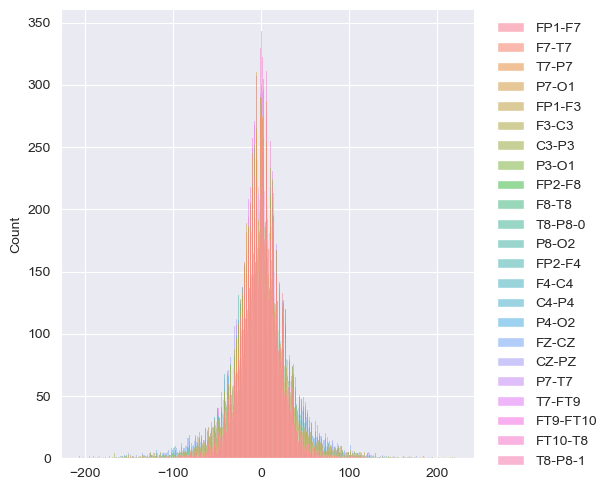

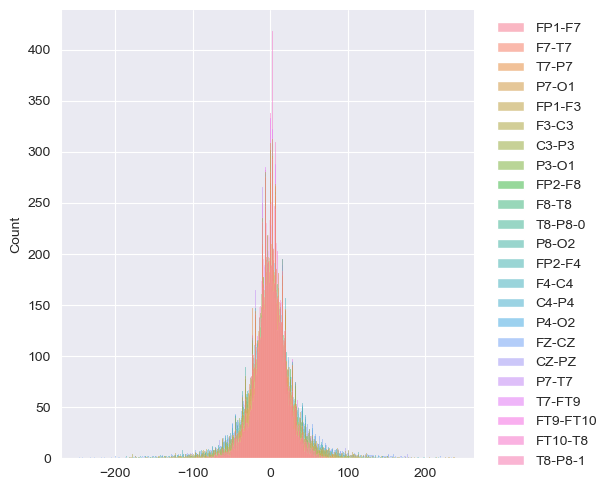

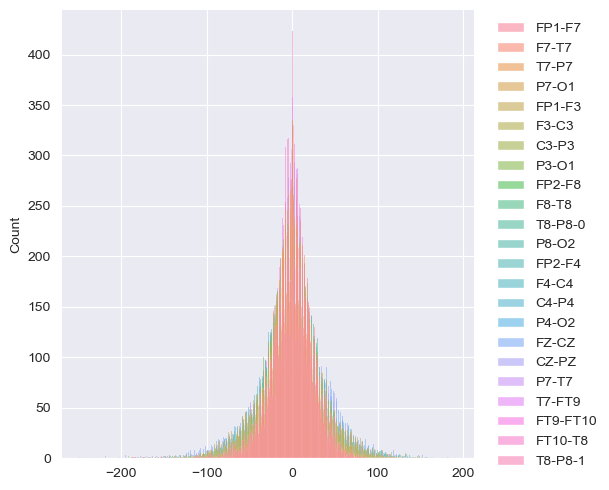

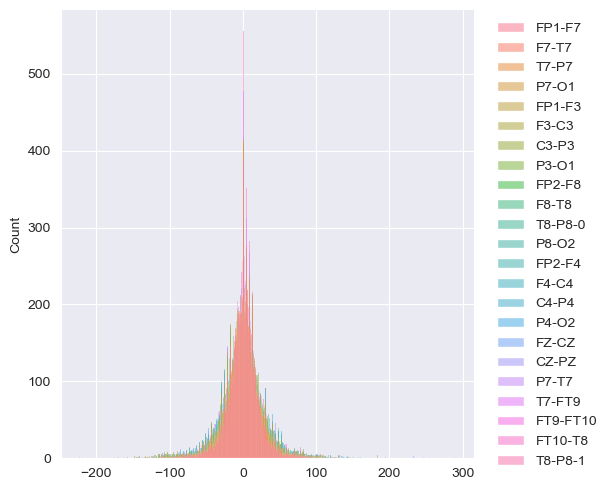

In [121]:
n, p, a, s = distribution_plot(data=norm, kind='hist', legend = True), \
			 distribution_plot(data=pre, kind='hist', legend = True), \
			 distribution_plot(data=aura, kind='hist', legend = True), \
			 distribution_plot(data=seizure, kind='hist', legend = True)

print(n, p, a, s)

The seizure has fewer columns on the higher end of counts and as before, the std seems to be narrower, possibly meaning the brain is "focused" on something we yet don't understand.

Let's compare the three sets' means versus the seizure means in each EEG lead in order as they occur starting with the set furthest out from the seizure:

norm v. seizure ->>>>>> pre_aura v. seizure ->>>>>> aura v. seizure

<AxesSubplot:xlabel='mean_a_norm', ylabel='mean_seizure'>

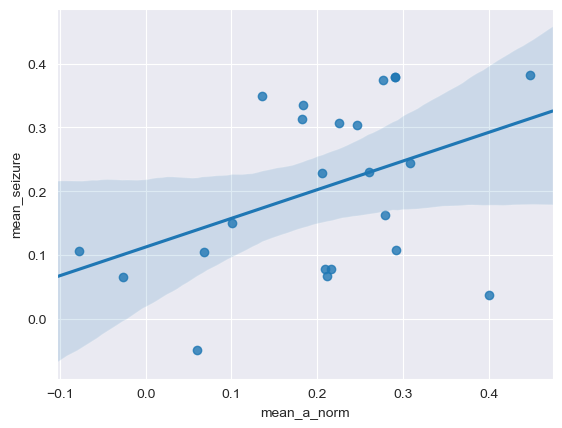

In [122]:
sns_line(reduced_sets, 'mean_a_norm', 'mean_seizure',  truncate=False, logx=False)

The means are slightly correlated. The seizure mean rises as the set’s mean rises, although we know this is the set furthest out from the seizure.
But could this mean the “energy” is building? And if so, when did it start building? Did we go back far enough to catch the pre_aura or the aura?
The seizure start time is 2996 seconds and its end time is 3036 seconds. All data sets equalling 40 seconds, while a good starting point, may not be accurate.
That’s something to consider when final decisions are being made.
Now the next set, where I hope to identify a pre_aura.

<AxesSubplot:xlabel='mean_b_pre_aura', ylabel='mean_seizure'>

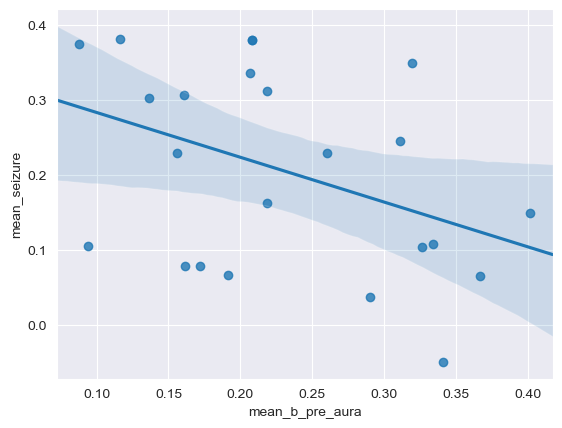

In [123]:
sns_line(reduced_sets, 'mean_b_pre_aura', 'mean_seizure', truncate=False, logx=False)

The mean decreases in the pre-aura phase as the mean for the seizure decreases, opposite the previous set and contradicting the theory that energy was building. Maybe the sets are big enough.

And the aura phase?

<AxesSubplot:xlabel='mean_c_aura', ylabel='mean_seizure'>

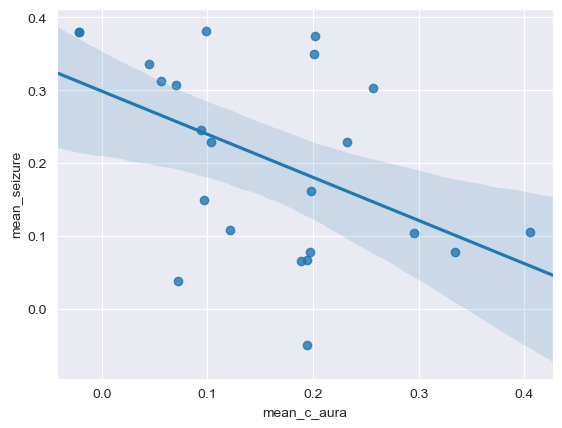

In [124]:
sns_line(reduced_sets, 'mean_c_aura', 'mean_seizure', truncate=False, logx=False)

And that trend continues with the set just before the seizure.

Let's link them chronologically starting with the set furthest out.

Note the y-axis represents the set closest to the seizure.

norm v. pre-aura ->>>>>> pre_aura v. aura ->>>>>> aura v. seizure

<AxesSubplot:xlabel='mean_a_norm', ylabel='mean_b_pre_aura'>

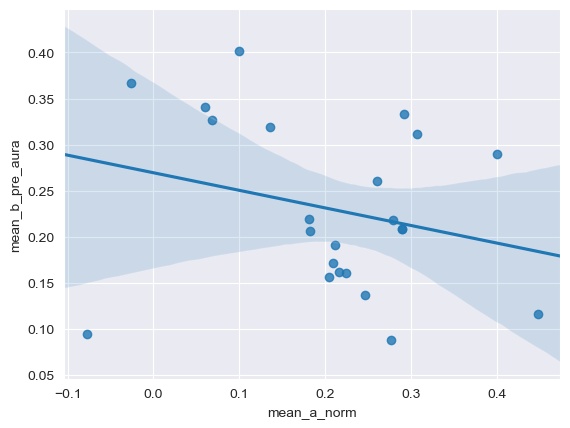

In [125]:
sns_line(reduced_sets, 'mean_a_norm', 'mean_b_pre_aura', truncate=False, logx=False)

<AxesSubplot:xlabel='mean_b_pre_aura', ylabel='mean_c_aura'>

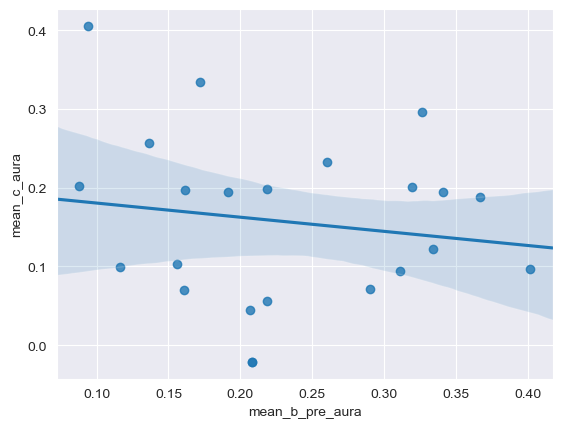

In [126]:
sns_line(reduced_sets, 'mean_b_pre_aura', 'mean_c_aura', truncate=False, logx=False)

<AxesSubplot:xlabel='mean_c_aura', ylabel='mean_seizure'>

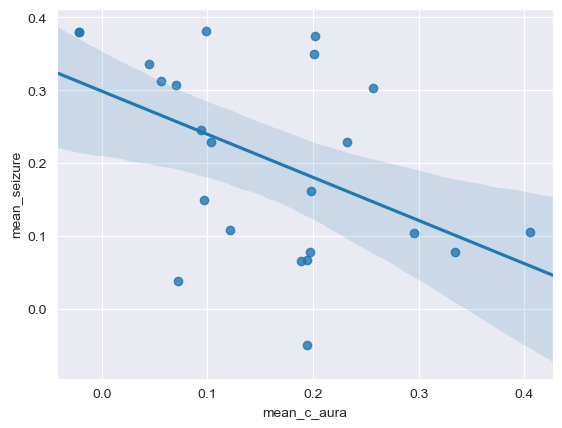

In [127]:
sns_line(reduced_sets, 'mean_c_aura', 'mean_seizure', truncate=False, logx=False)

Generally, the mean from the first set (furthest from the seizure) is increasing as the mean from the second set (closest to the seizure) is decreasing and this pattern continues all the way through the seizure, or the means are decreasing all the way through to the seizure. And that was the pattern seen earlier. And now I'm back on the sets-before-the-seizure-train-may-not-be-big-enough train. All three of these sets before the seizure  may be an aura.
  Again, something to consider at final decision time.

I need a sanity check. I chose quite the capstone project and sometimes I feel like I'm moving aimlessly. I need to make sure the laws of the universe still apply. Let's  do the plot with only the seizure set.

<AxesSubplot:xlabel='mean_seizure', ylabel='mean_seizure'>

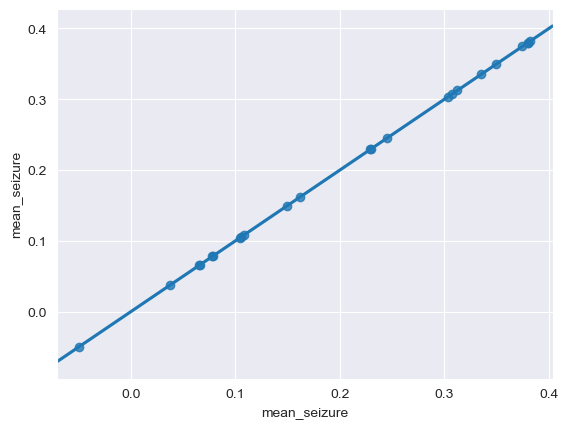

In [128]:
sns_line(reduced_sets, 'mean_seizure', 'mean_seizure', truncate=False, logx=False)

I'm still sane. Nothing to hint that I've moved into another universe  in the multiverse where the laws of physics are different.

So let's do the same thing for the summary columns which shows.

Here is the set for convenience.

In [129]:
reduced_summary_sets

,mean_a_norm,mean_b_pre_aura,mean_c_aura,mean_seizure
outer_left_hemi_sum,0.953967,0.686708,0.653057,0.927107
inner_left_hemi_sum,0.978766,0.754772,0.620818,0.943169
outter_right_hemi_sum,0.893304,1.143280,0.547299,0.871443
inner_right_hemi_sum,0.872931,1.129163,0.525628,0.852977
center_line,0.185383,0.557485,0.382747,0.131779
left_temple_to_left_rear,0.185383,0.557485,0.382747,0.131779
temple_to_temple,-0.077392,0.094180,0.405466,0.105625
right_temple_to_right_rear,0.581903,0.541690,0.100227,0.488086


And the layout, like above, looks like this:

norm v. seizure ->>>>>> pre_aura v. seizure ->>>>>> aura v. seizure

<AxesSubplot:xlabel='mean_a_norm', ylabel='mean_seizure'>

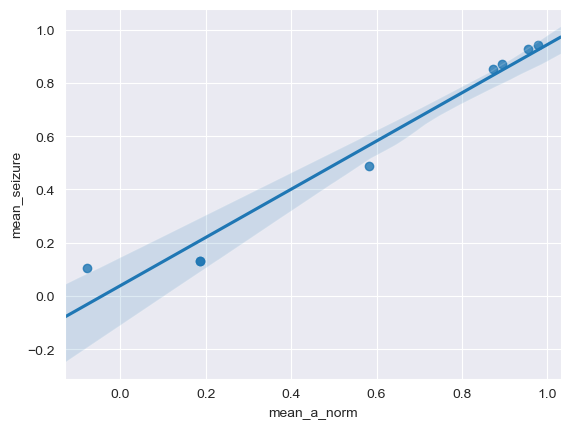

In [130]:
sns_line(reduced_summary_sets, 'mean_a_norm', 'mean_seizure',  truncate=False, logx=False)

<AxesSubplot:xlabel='mean_b_pre_aura', ylabel='mean_seizure'>

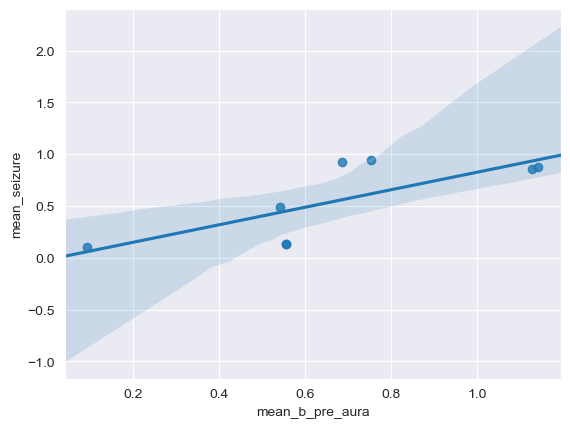

In [131]:
sns_line(reduced_summary_sets, 'mean_b_pre_aura', 'mean_seizure',  truncate=False, logx=False)

<AxesSubplot:xlabel='mean_c_aura', ylabel='mean_seizure'>

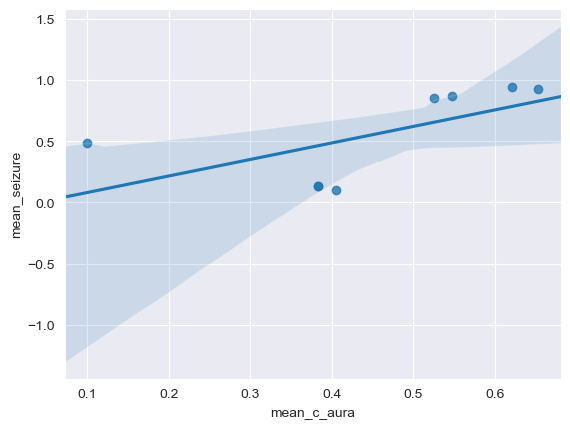

In [132]:
sns_line(reduced_summary_sets, 'mean_c_aura', 'mean_seizure',  truncate=False, logx=False)

That's strange.
Previously when we compared each set to the seizure set, it increased and decreased all the way to the seizure.
In the summary columns, it's increasing all the way.

Let's link them chronologically starting with the set furthest out as we did earlier.

Remember the y-axis represents the set closest to the seizure.

norm v. pre-aura ->>>>>> pre_aura v. aura ->>>>>> aura v. seizure

<AxesSubplot:xlabel='mean_a_norm', ylabel='mean_b_pre_aura'>

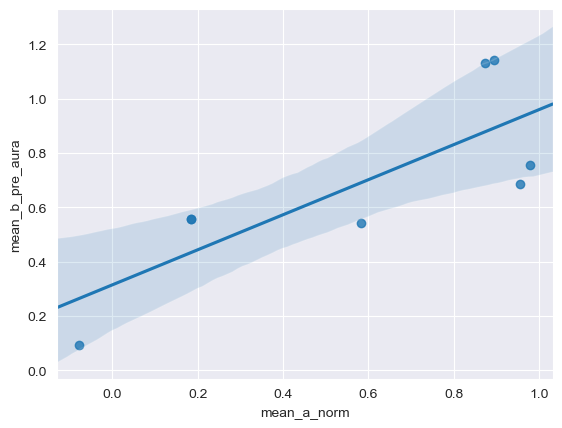

In [133]:
sns_line(reduced_summary_sets, 'mean_a_norm', 'mean_b_pre_aura',  truncate=False, logx=False)

<AxesSubplot:xlabel='mean_b_pre_aura', ylabel='mean_c_aura'>

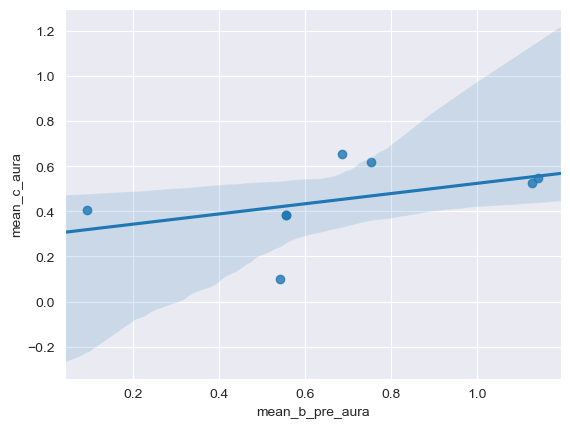

In [134]:
sns_line(reduced_summary_sets, 'mean_b_pre_aura', 'mean_c_aura',  truncate=False, logx=False)

<AxesSubplot:xlabel='mean_c_aura', ylabel='mean_seizure'>

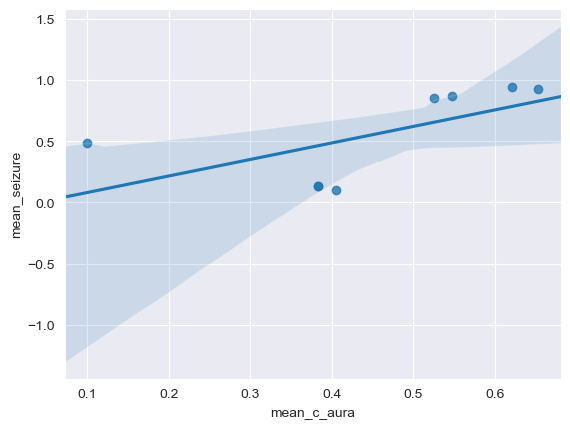

In [135]:
sns_line(reduced_summary_sets, 'mean_c_aura', 'mean_seizure',  truncate=False, logx=False)

Again strange. Earlier, these same 3 comparisons all decreased all the way to the seizure and again they are all increasing to the seizure.

I'm starting to think I've missed something.

And after review, I have missed something.

Except for the summary columns, the analysis has been taking summary stats from one EEG lead over THE ENTIRE TIME RANGE.  Or, I have the mean for a lead for almost an hour and half.

As opposed to the summary columns which are taking a summation OVER EACH LEAD IN AN INSTANCE IN TIME.

So instead of looking at a single column over all time, we need to look at all columns in an instance of time (a row)  and see what the changes are.

This may mean everything above is irrelevant and serves only to demonstrate my Springboard-taught skills though out the EDA phase.

Let's review an earlier photo.

![](dont_trash_.jpeg)

So far, the summary columns are:

They are:
'outer_left_hemi_sum',
 'inner_left_hemi_sum',
 'outter_right_hemi_sum',
 'inner_right_hemi_sum',
 'center_line',
 'left_temple_to_left_rear',
 'temple_to_temple',
 'right_temple_to_right_rear'

The photo doesn't include the columns 'left_temple_to_left_rear', 'temple_to_temple', or 'right_temple_to_right_rear' because the photo doesn't need to be that detailed to understand the ideas.

The red arrows on the right identify the outter right hemisphere.

The three leads inside that semi-circle are the inner right hemisphere.

One idea will be to look at how these hemispheres change over time and then how is that different from the hemispheres during the seizure.

Back to the photo, and between the x's, is the 'center_line', which is above the Corpus Colosseum, which allows information to pass from one hemisphere to the other, if it hasn't been cut, as is the case with my daughter. We don't have that information about the patients in this capstone, so we'll assume they are NOT cut, and energy can move throughout the brain since that is the most probable scenario (cutting this bundle of nerves is a near last step and amounts to a hail mary to stop seizures). Those x's in the photo are there as guideposts when placing the leads on the head and do not take any measurements so they don't impact the analysis.

The left hemisphere with 'outer_left_hemi_sum' and 'inner_left_hemi_sum' is the mirror image of the right hemisphere's description.

Now let's imagine a seizure at least as far as I understand it:

Neurons in a section of the brain create electricity and, due to the brain's inability to steer or control the spread of that energy, the energy moves to other parts of the brain, activating them, resulting in some uncontrollable effects in the patient.

For example, non-epileptics hear a sound that initiates electricity in a part of the brain that may lead to a memory from the past, or it may start adrenal glands that tell us to run. In  other words, the brain directs the electricity only to the appropriate areas needed in the moment.

An epileptic hears the sound, and the brain cannot direct the electricity to ONLY  the appropriate areas needed in the moment. Rather it spreads uncontrollably to other parts of the brain, activating them, which can result in undesirable affects and/or movements that can cause injury.

An example would be an epileptic hears a sound, the energy spreads to an area of the brain that controls breathing, the energy overwhelms that part and breathing stops. If this patient dies, this would be a called a SUDEP seizure, and if the patient isn't monitored (like my daughter is 24-7) and some form of high-octane benzo isn't administered to immediately shut the brain down, the patient dies.

Initial steps to control seizures are usually medicines that, in some form or another, attempt to reduce the seizure's ability to "jump" across the synapse into other parts of the brain, containing it to a limited area. In the picture below from Khan Academy, electricity is released from a neuron and travels to the synapse, jumping to a receiving neuron. In a seizure, the electricity jumps any and all neurons, whereas, in a non-epileptic, the electricity doesn't jump synapses that aren't relevant to the task at hand.

![](dont_selete_2.jpg)

So why the elaborate explanation other than it's seriously interesting?

It reveals the plan of attack on this analysis.

The data set tells us where the seizure begins and at that point, we can register what the EEG readings are at a point of time. Those readings will also identify which leads are registering the most electricity, which in turn, theoretically, identifies the seizure's source location in the brain.

I'm not sure that we even care about the data after the seizure begins. So can we drop everything after the seizure’s onset, creating a single column in time of readings known to be a seizure? I think so.

I posit that this is an idealistic approach, because the numbers in the columns will not always be the same from seizure to seizure and from patient to patient.

But it's a start.

So as we begin to review the summary stats and distributions in the "my epiphany" sets, we will hopefully find other patterns that will assist in the "prior probabilities" used in the coming modeling stage.

The next block of code sets up everything discussed above.

I'll drop the columns identified earlier has having dropped in energy, focusing only on the left and right hemispheres.

I think we may be interested in the means for each section of the brain with respect to any instant in time, so I'll add those columns.

I will also shorten the dataframes considerably, remembering that each of these is the concatenation of a huge set that didn't contain a seizure with another huge set that did. 10241 lines of code amounts to about 40 seconds, which was the length of the seizure.

So like above when I spilt them into norm, pre, aura, and seizure, the following sets will include the rows associated with that amount of time and all of the new sets will end in ONLY the row that marks the start of the seizure.

However, since there was contradictory evidence above concerning if I'd gone out far enough to catch the start of any preseizure, Ill add another block of 10,241 rows, or ~ 40,000 rows.  All told, each set will contain about 160 seconds of readings.

I'll have to transpose these dataframes for modeling, since the point in time that marks the start of the seizure will be the y_train, so I'll make those because I'm already here doing it, but probably won't use them in the EDA phase.

Remember at the start of the notebook, I said:
"It’s important to understand that I couldn’t come up with a plan to split a single X and y into training and testing sets. I couldn’t quickly find a way to make a 10,000 x 23 matrix of data points a “target” dataframe."

It's obvious now that throughout this EDA phase, the analysis lead to a solution to this and I will be able to split a single seizure set into X_train, X_test, y_train, y_test, and train the model on all three patient sets.

The sets will then be:
1. P1_raw: the master set whose rows include the X train and the final y train row
2. X_P1: P1_raw without the final row
3. y_P1: P1_raw's final row
4. X_P1_summary: P1_raw's summary columns without the final row
5. y_P1_summary: P1_raw's  the final row summariess
6. X_P1_Transpose: the transpose of 2
7. y_P1_Transpose: the transpose of 3

In [136]:
my_epiphany_P1 = master_data_patient_dict['Patient 1 initial set']['all data minus seizure column'].iloc[1657852:1688577,:]

my_epiphany_P1.drop(
		['P7-T7','T7-FT9','left_temple_to_left_rear','FT9-FT10','temple_to_temple','FT10-T8','T8-P8-1',
		 'right_temple_to_right_rear','FZ-CZ','CZ-PZ','center_line'],inplace=True,axis=1)

my_epiphany_P1.insert(5,'outer_left_hemi_mean', my_epiphany_P1.outer_left_hemi_sum / 4)
my_epiphany_P1.insert(11,'inner_left_hemi_mean', my_epiphany_P1.inner_left_hemi_sum / 4)
my_epiphany_P1.insert(17,'outter_right_hemi_mean', my_epiphany_P1.outter_right_hemi_sum / 4)
my_epiphany_P1.insert(23,'inner_right_hemi_mean', my_epiphany_P1.inner_right_hemi_sum / 4)


my_epiphany_master_columns = list(enumerate(my_epiphany_P1.columns.to_list()))

P1_raw = my_epiphany_P1[[
		my_epiphany_master_columns[0][1],
		my_epiphany_master_columns[1][1],
		my_epiphany_master_columns[2][1],
		my_epiphany_master_columns[3][1],
		my_epiphany_master_columns[6][1],
		my_epiphany_master_columns[7][1],
		my_epiphany_master_columns[7][1],
		my_epiphany_master_columns[9][1],
		my_epiphany_master_columns[12][1],
		my_epiphany_master_columns[13][1],
		my_epiphany_master_columns[14][1],
		my_epiphany_master_columns[15][1],
		my_epiphany_master_columns[18][1],
		my_epiphany_master_columns[19][1],
		my_epiphany_master_columns[20][1],
		my_epiphany_master_columns[21][1]]]

P1_summary = my_epiphany_P1[[
		my_epiphany_master_columns[4][1],
		my_epiphany_master_columns[5][1],
		my_epiphany_master_columns[10][1],
		my_epiphany_master_columns[11][1],
		my_epiphany_master_columns[16][1],
		my_epiphany_master_columns[17][1],
		my_epiphany_master_columns[22][1],
		my_epiphany_master_columns[23][1]]]

X_P1 = P1_raw.iloc[:-1,:]
y_P1 = P1_raw.iloc[-1:,:]

X_P1_summary = P1_summary.iloc[:-1,:]
y_P1_summary = P1_summary.iloc[-1:,:]

X_P1_Transpose = X_P1.T
y_P1_Transpose = y_P1.T

master_data_patient_dict['Patient 1 model sets'] = {
		'P1_raw': P1_raw,
		'X_P1': X_P1,
		'y_P1': y_P1,
		'X_P1_summary': X_P1_summary,
		'y_P1_summary': y_P1_summary,
        'X_P1_Transpose': X_P1.T,
        'y_P1_Transpose': y_P1.T}


This technically ends the EDA segment and I've spent a week and a half analyzing the data as can be seen from the extensive notes.
This was not equivalent to analyzing housing prices in some neighborhoods around a city.

This certainly set me back in the overall course, and that began to eat at me in the last couple days as I have not turned in an assignment at all this week, but I didn't feel as though I should rush this phase due to the complexity of the material.

I've decided on the final models sets for: X_P1_Transpose and y_P1_Transpose, all that'll be left is to get the other two patient EEGs into this form.

I think in general, the X data is chaotic, much like the brain, and due that characteristic, Bayesian Modeling will be the way to go.

As a rough framework, I know the seizure is in the set, so if the question is 'What's the probability that a seizure will occur given the data' (without the seizure in it), I'd have to say the "prior probability" is 1, because I've seen the data, but that is going to produce a useless model. Nothing is ever 1, nor is anything ever 0, according to Probability Theory.

The idea in Bayes is you guess a "prior probability" and pick a random variable from a distribution, (seen above, the distribution is normal with all the data in 1.6 million rows, thus the Central Limit Theorem can be used), then choose a likelihood distribution (I'm still in the leaning of this process in my spare time), and that produces a "posterior probability," and this the "posterior" becomes the "prior" and the process is iterated.

So maybe the posteriors will come from smaller sections of the X set and it iterates until it gets close to the actual values of the y????

With all that said, the rubric for this section follows my responses to ensure I haven't missed anything.

Completion

Every feature is investigated using either histograms, bi-plots, or other visual and numeric means.
   While I only looked at the histograms for a few of the variables, I think the nature of the data will show they are all normally distributed around a mean close to 0 and an std in the 70s for X and 50s for the seizure set, demonstrating that the seizure seems to 'focus' things.

Pearson correlation coefficients and other statistical methods were used to identify statistical relationship strengths.
   The pair plots and sns plots showed may not be able to considered as relevant since the no doubt is correlated with itself.


Process and understanding
The submission shows that the student understands how to explore feature relationships in the data.
The submission demonstrates that the student made data-supported decisions on when to select specific features.
   I hope my lengthy explanations demonstrated this.


Presentation
Jupyter Notebook with all the applied code steps in working order and with notation or comments as needed.
The submission is complete and uploaded in full to the Github repo.
   I'm colorblind and springboard teaches not to get fancy so I strive to keep it very simple.

Nonetheless, I's like to answer one of the questions above:.


In [137]:
X_transition = master_data_patient_dict['Patient 1 model sets']['X_P1_Transpose'][[1688565, 1688567, 1688568, 1688569, 1688570, 1688571, 1688572, 1688573, 1688574, 1688575]].mean()
y_transition = master_data_patient_dict['Patient 1 model sets']['y_P1_Transpose'][[1688576]].mean()
print(f'The final 10 rows of the X set:\n{X_transition}\n\nThe seizure row:\n{y_transition}')


The final 10 rows of the X set:
1688565    18.266178
1688567    26.324786
1688568    27.032967
1688569    26.568987
1688570    29.377289
1688571    28.327228
1688572    22.661783
1688573    19.365079
1688574    18.852259
1688575    16.239316
dtype: float64

The seizure row:
1688576    10.549451
dtype: float64


The mean electrical readings dropped considerably from one 1/256 of a second to the next and there was overall decrease leading to the seizure.
What's the % drop?

In [138]:
10.54 / 16.24

0.6490147783251231

About a 33% drop in electrical readings.
What about the standard deviations

In [139]:
X_transition_std = master_data_patient_dict['Patient 1 model sets']['X_P1_Transpose'][[1688565, 1688567, 1688568, 1688569, 1688570, 1688571, 1688572, 1688573, 1688574, 1688575]].std()
y_transition_std = master_data_patient_dict['Patient 1 model sets']['y_P1_Transpose'][[1688576]].std()
print(f'The final 10 rows of the X set:\n{X_transition_std}\n\nThe seizure row:\n{y_transition_std}')

The final 10 rows of the X set:
1688565    36.048200
1688567    33.203686
1688568    28.974745
1688569    24.893111
1688570    16.941063
1688571    20.806977
1688572    29.844491
1688573    32.756406
1688574    31.324471
1688575    31.050668
dtype: float64

The seizure row:
1688576    27.262094
dtype: float64


And that drop?

In [140]:
27.3 / 31.1

0.8778135048231511

23%. Things got more focused.

How about with summaries, representing the brain regions.

In [141]:
a = len(master_data_patient_dict['Patient 1 model sets']['X_P1_summary'].columns)
sums_X = master_data_patient_dict['Patient 1 model sets']['X_P1_summary'].iloc[:,[i for i in range(1, a, 2)]]
sums_y = master_data_patient_dict['Patient 1 model sets']['y_P1_summary'].iloc[:,[i for i in range(1, a, 2)]]
summin = pd.concat([sums_X, sums_y])
summin.tail()

,outer_left_hemi_mean,inner_left_hemi_mean,outter_right_hemi_mean,inner_right_hemi_mean
1688572,23.345543,23.443223,21.782662,21.782662
1688573,19.340659,19.731380,18.754579,18.656899
1688574,16.214896,16.507937,21.391941,21.489621
1688575,12.112332,12.112332,21.196581,21.294261
1688576,6.739927,6.935287,15.335775,15.238095


Remember the last row is the start of the seizure.

I would say the seizure is certainly in the left hemisphere. A drop of half in electrical readings. And about a 2/7 drop in the right hemisphere.
And things are decreasing up to that point.

Scanning up the dataset, I didn't see any significant drops like that.

I think as the model approaches, significant drops in output in the left hemisphere is something to look out for.

<AxesSubplot:>

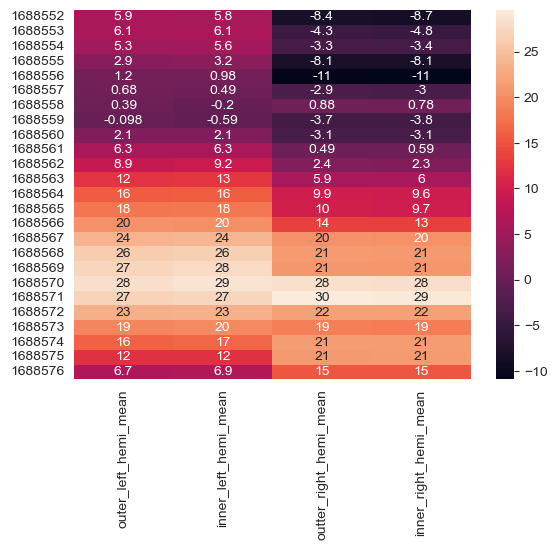

In [142]:
sns.heatmap(data=summin.iloc[30700:], annot=True)

That told us what we already knew.
How about...

<AxesSubplot:>

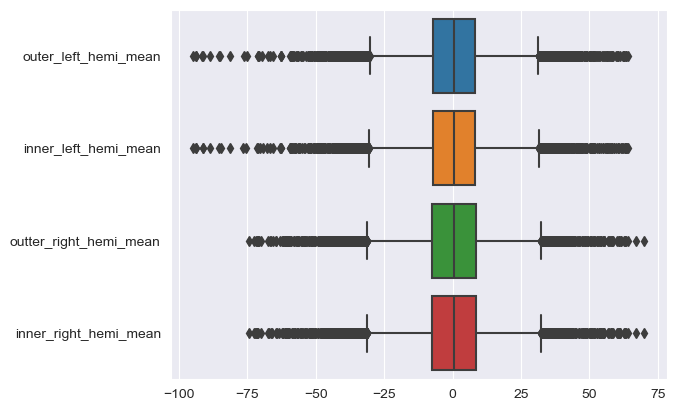

In [143]:
sns.boxplot(data=summin, orient='h')

That's depressing. How about...

<AxesSubplot:ylabel='Density'>

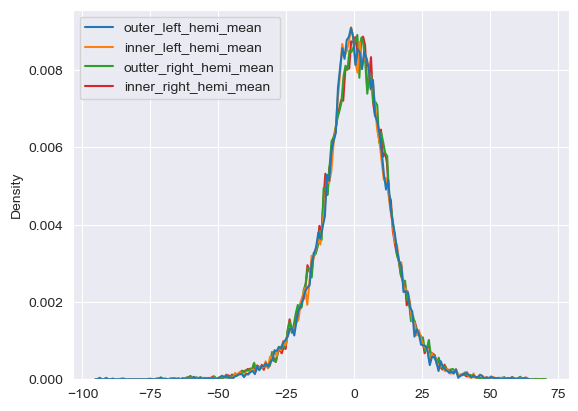

In [144]:
sns.kdeplot(data=summin,bw_adjust=0.1)

Don't think "it" is happening. "It" being looking at this issue from an Frequentest POV.
Bayesian it is.
And time to move on.
